<h1 align="center">2019 Final</h1>
<h4 align="center">Ziyuan Shen, NetID: zs83</h4>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm_notebook as tqdm
from scipy.stats import norm
import keras
from keras import metrics
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout, Lambda, Input, Reshape, Conv2DTranspose
seed_value= 0
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)
# 3. Set `numpy` pseudo-random generator at a fixed value
# 4. Set `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.set_random_seed(seed_value)
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


#### Pr. 1.1
Consider the data set in Lab 1. This is the Advertisement.csv data set.

In [2]:
ad_df = pd.read_csv('Advertisement.csv')
X_ad = ad_df[['TV','radio','newspaper']].values
y_ad = ad_df.sales.values

1.Compute the leave-one-out cross validation error for a Gaussian process regression
model as well as a Convolutional Neural Network.

Gaussian process regression:

A simple radius basis function kernel is used, which is defined as,
\begin{equation}
K(x,x')=exp\left (-\frac{||x-x'||^2}{2}\right )
\end{equation}

noise is set to $0.1$,

In [3]:
kernel = RBF(length_scale=1)
gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0)

Cross-Validation error is defined as:
\begin{equation}
I[cv]=\frac{1}{n}\sum_{i=1}^{n}{(y_i-{\hat{f}}_{D^{\backslash i}}(x_i))}^2
\end{equation}

According to this formula, the cross validation error for Gaussian process regression is computed as follows:

In [4]:
loo = LeaveOneOut()

In [5]:
error_list1 = []
for train_index, test_index in tqdm(loo.split(X_ad),total=len(list(loo.split(X_ad))),leave=False):
    X_train, X_test = X_ad[train_index], X_ad[test_index]
    y_train, y_test = y_ad[train_index], y_ad[test_index]
    gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0)\
    .fit(X_train, y_train)
    y_hat = gpr.predict(X_test)
    error = (y_hat - y_test) ** 2
    error_list1.append(error)
I_cv = sum(error_list1) / len(error_list1)
print('Cross validation error for Gaussian process regression : {}'.format(I_cv[0]))

Cross validation error for Gaussian process regression : 0.43839471117738127


Convolutional nueral network:

As the advertisement dataset has $1$ dimensional data of $3$ features, I reshape it to $3\times1\times1$ size in order to implement convolutional neural network. A $8\times1\times1$ convolutional layer, pooling layer and a fully-connected layer with $4$ neurons are added.

In [6]:
model_cnn = Sequential()
model_cnn.add(Conv2D(8, (1, 1), padding='valid', input_shape=(3,1,1))) 
model_cnn.add(Activation("relu"))
model_cnn.add(MaxPooling2D(pool_size=(1, 1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(4))
model_cnn.add(Activation("relu"))
model_cnn.add(Dense(1, activation='linear'))
model_cnn.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [8]:
error_list2 = []
for train_index, test_index in tqdm(loo.split(X_ad),total=len(list(loo.split(X_ad))),leave=False):
    X_train, X_test = X_ad[train_index], X_ad[test_index]
    y_train, y_test = y_ad[train_index], y_ad[test_index]
    X_train = X_train.reshape(X_train.shape[0], 3, 1, 1)
    X_test = X_test.reshape(X_test.shape[0], 3, 1, 1)
    np.random.seed(2019)
    model_cnn.fit(X_train, y_train, batch_size=50, epochs=20, verbose=0, validation_split=0.2)
    y_hat = model_cnn.predict(X_test)
    error = (y_hat - y_test) ** 2
    error_list2.append(error)
I_cv = sum(error_list2) / len(error_list2)
print('Cross validation error for Convolutional neural network: {}'.format(I_cv[0][0]))

Cross validation error for Convolutional neural network: 0.6474606997827935


2.Plot the predictive posterior distribution when observations 1, 50, 100, 150 are respectively left out of the training set and you are asked to predict their response

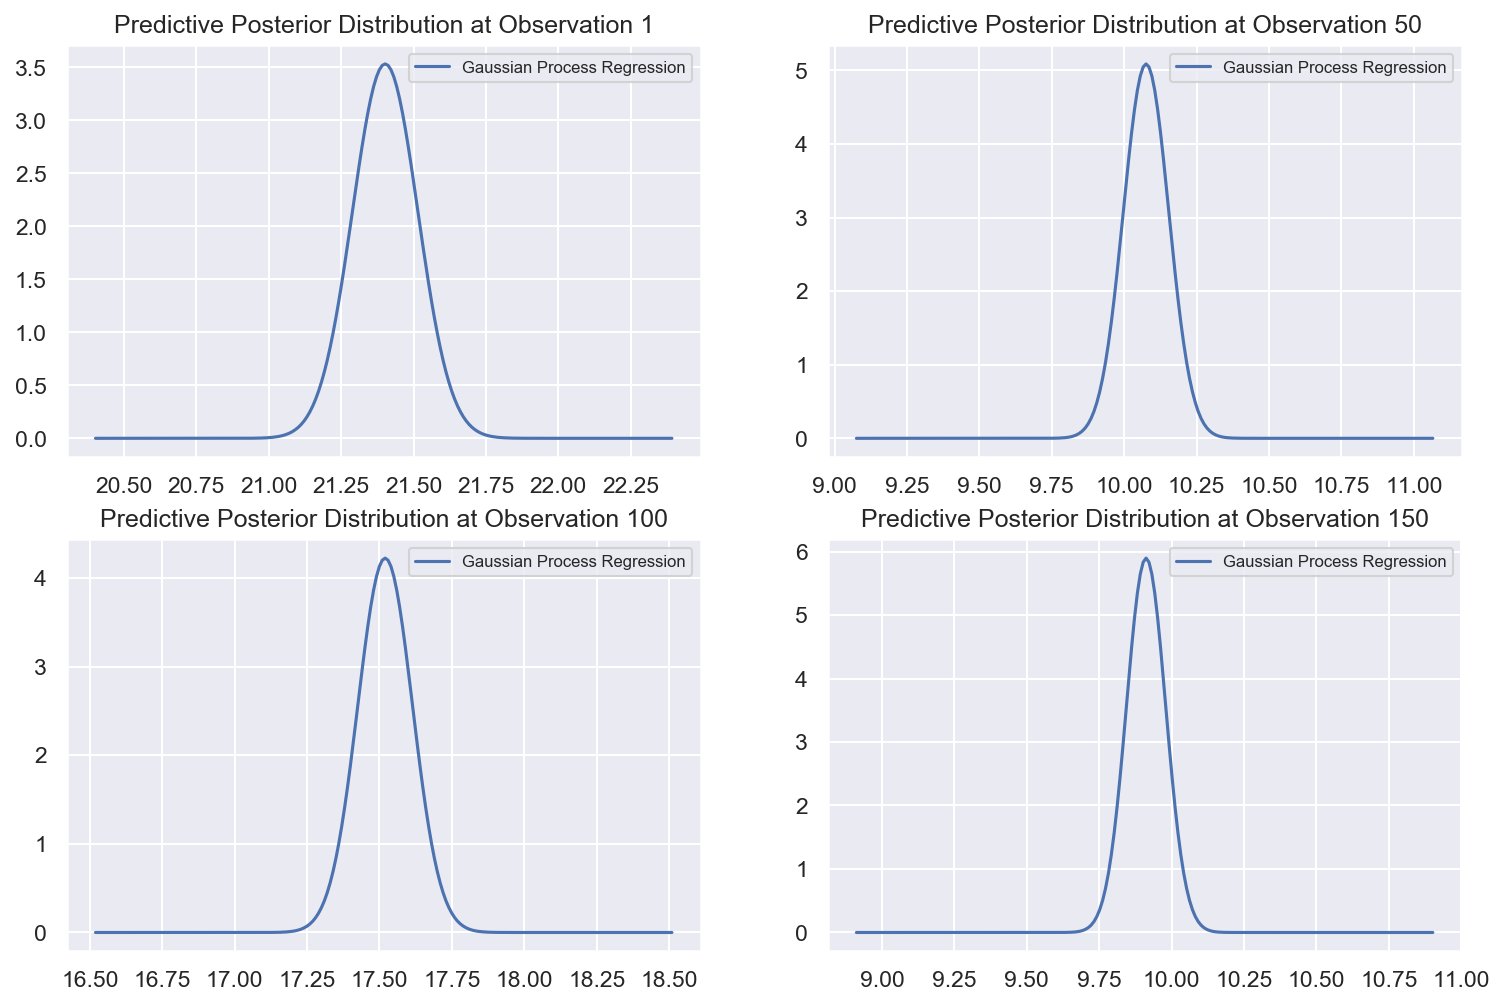

In [9]:
fig = plt.figure(figsize=(12,8),dpi=150)
for i, idx in enumerate([0,49,99,149]):
    X_train = X_ad[np.arange(X_ad.shape[0])!=idx]
    y_train = y_ad[np.arange(X_ad.shape[0])!=idx]
    X_test = X_ad[idx:idx+1]
    y_test = y_ad[idx:idx+1]
    gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0).fit(X_train, y_train)
    mu, std = gpr.predict(X_test, return_std=True)
    x_axis = np.arange(-1+mu, 1+mu, 0.01)
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(x_axis, norm.pdf(x_axis,mu,std), label='Gaussian Process Regression')
    ax.legend(loc='upper right', prop={'size': 8})
    ax.set_title("Predictive Posterior Distribution at Observation {}".format(idx+1))

#### Pr. 1.2

Consider the MNIST data at http://yann.lecun.com/exdb/mnist/index.html (you can use the entire data or a subset, just tell me what you did)

1.Use a spectral embedding method to project this data into 3-dimensions. Show some plots and provide a number.metric of how closely distances have been preserved via the embedding.

A random subset of $500$ MNIST data is used here.

In [10]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
np.random.seed(2019)
index = np.random.choice(70000, 500, replace=False)
X_mnist = mnist.data[index,:]
y_mnist = mnist.target[index]

/Users/alice/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/Users/alice/anaconda3/envs/tensorflow_env/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


A linear kernel PCA embedding method is employed here to transform the data into $3$ dimensions. A 3D plot as well as pairwise plot of every two components are provided. In the scatter plot, each kind of digit is represented by a unique color. From the plot, we can observe that same digits tend to cluster together.

In [11]:
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=3, kernel='linear')
X_transformed = transformer.fit_transform(X_mnist/255)

In [12]:
compo1 = X_transformed[:,0]
compo2 = X_transformed[:,1]
compo3 = X_transformed[:,2]
cmap = plt.cm.get_cmap('gist_rainbow', 11)

Text(0.5, 0.9, 'First Three PCA Visualization')

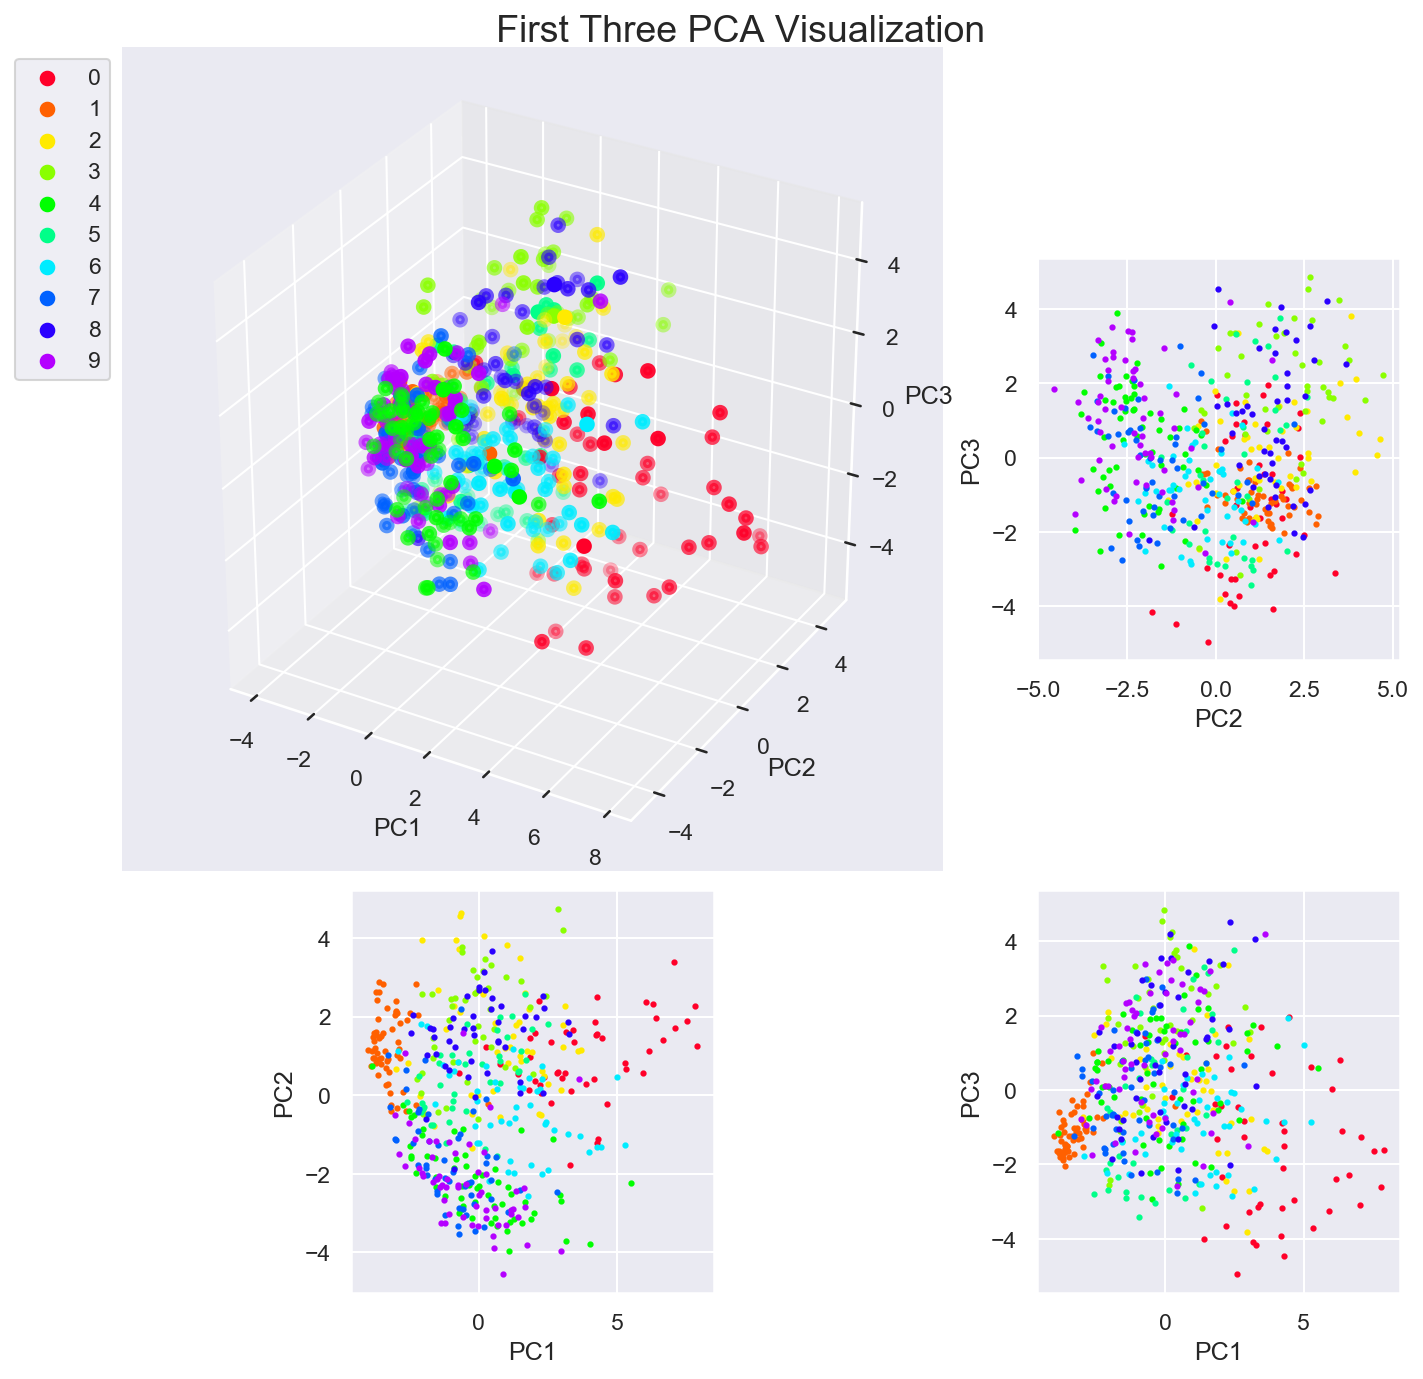

In [13]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(dpi=150, figsize=(11,11))
grid = plt.GridSpec(6, 6, hspace=0.1, wspace=0.7)
ax1 = fig.add_subplot(grid[:4, :4], projection='3d')
ax1.set_xlabel("PC1")
ax1.set_ylabel("PC2")
ax1.set_zlabel("PC3")
ax2 = fig.add_subplot(grid[4:, 1:3])
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
ax3 = fig.add_subplot(grid[1:3, 4:])
ax3.set_xlabel("PC2")
ax3.set_ylabel("PC3")
ax4 = fig.add_subplot(grid[4:, 4:])
ax4.set_xlabel("PC1")
ax4.set_ylabel("PC3")
for i in range(10):
    ax1.scatter(compo1[y_mnist==i], compo2[y_mnist==i], compo3[y_mnist==i], c=[cmap(i/10)], linewidths=3, label='{}'.format(i))
    ax2.scatter(compo1[y_mnist==i], compo2[y_mnist==i], c=[cmap(i/10)], s=4)
    ax3.scatter(compo2[y_mnist==i], compo3[y_mnist==i], c=[cmap(i/10)], s=4)
    ax4.scatter(compo1[y_mnist==i], compo3[y_mnist==i], c=[cmap(i/10)], s=4)
ax1.legend(bbox_to_anchor=(0, 1))
fig.suptitle("First Three PCA Visualization", y=0.9, fontsize=18)

Pairwise distances of the original data and the transformed data can be computed for comparison to observe how distances are preserved before and after the transformation:

In [14]:
from sklearn.metrics import pairwise_distances
pairwise_distances(X_mnist/255, metric='l2')

array([[ 0.        , 10.37186995,  9.37554797, ..., 13.18634376,
        13.230896  , 12.59031136],
       [10.37186995,  0.        ,  9.653767  , ...,  9.8884886 ,
        10.63790167,  9.04857242],
       [ 9.37554797,  9.653767  ,  0.        , ..., 12.28688032,
        11.4840069 , 11.60679049],
       ...,
       [13.18634376,  9.8884886 , 12.28688032, ...,  0.        ,
         9.40730041,  8.54355825],
       [13.230896  , 10.63790167, 11.4840069 , ...,  9.40730041,
         0.        ,  9.55765282],
       [12.59031136,  9.04857242, 11.60679049, ...,  8.54355825,
         9.55765282,  0.        ]])

In [15]:
pairwise_distances(X_transformed, metric='l2')

array([[ 0.        ,  5.74492545,  2.59094018, ..., 10.45673818,
         8.17704066,  8.7155474 ],
       [ 5.74492545,  0.        ,  5.15181224, ...,  4.77088045,
         3.4339341 ,  3.2967513 ],
       [ 2.59094018,  5.15181224,  0.        , ...,  9.46839622,
         6.69119919,  8.43977899],
       ...,
       [10.45673818,  4.77088045,  9.46839622, ...,  0.        ,
         4.06947048,  3.09543525],
       [ 8.17704066,  3.4339341 ,  6.69119919, ...,  4.06947048,
         0.        ,  4.49880102],
       [ 8.7155474 ,  3.2967513 ,  8.43977899, ...,  3.09543525,
         4.49880102,  0.        ]])

2.Use a variational autoencoder to project this data into 3-dimensions. Show some plots and provide a number.metric of how closely distances have been preserved via the embedding.

Here I use a random subset of $10000$ data points, of which $8000$ data points are set as training data and $2000$ data points are set as validation data. The implementation of variational autoencoder refers Kaggle code (https://www.kaggle.com/rvislaywade/visualizing-mnist-using-a-variational-autoencoder). The number of latent dimensions is change to $3$ here. So after encoding, the data is reduced to $3$ dimensions. Similar to PCA, a 3D plot as well as pairwise plot of every two dimensions are provided. Pairwise distances are computed for evaluating how distances are preserved before and after projection.

In [16]:
np.random.seed(2019)
ind = np.random.choice(70000, 10000, replace=False)
X_train = (mnist.data[ind,:][:8000]/255).reshape(-1, 28, 28, 1)
X_valid = (mnist.data[ind,:][8000:]/255).reshape(-1, 28, 28, 1)
y_train = mnist.target[ind][:8000]
y_valid = mnist.target[ind][8000:]

In [17]:
K.clear_session()
np.random.seed(2019)

In [18]:
img_shape = (28, 28, 1)
batch_size = 16
latent_dim = 3
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = Conv2D(32, 3, padding='same', activation='relu')(input_img)
x = Conv2D(64, 3, padding='same', activation='relu', strides=(2, 2))(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
x = Conv2D(64, 3, padding='same', activation='relu')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = Flatten()(x)
x = Dense(32, activation='relu')(x)

# Two outputs, latent mean and (log)variance
z_mu = Dense(latent_dim)(x)
z_log_sigma = Dense(latent_dim)(x)

In [19]:
# sampling function
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = Lambda(sampling)([z_mu, z_log_sigma])

In [20]:
# decoder takes the latent distribution sample as input
decoder_input = Input(K.int_shape(z)[1:])

# Expand to 784 total pixels
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_input)

# reshape
x = Reshape(shape_before_flattening[1:])(x)

# use Conv2DTranspose to reverse the conv layers from the encoder
x = Conv2DTranspose(32, 3, padding='same',  activation='relu', strides=(2, 2))(x)
x = Conv2D(1, 3, padding='same', activation='sigmoid')(x)

# decoder model statement
decoder = Model(decoder_input, x)

# apply the decoder to the sample from the latent distribution
z_decoded = decoder(z)

In [21]:
# construct a custom layer to calculate the loss
class CustomVariationalLayer(keras.layers.Layer):
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # Reconstruction loss
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1)
        return K.mean(xent_loss + kl_loss)

    # adds the custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = CustomVariationalLayer()([input_img, z_decoded])

In [22]:
vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()
vae.fit(x=X_train, y=None, shuffle=True, epochs=4, batch_size=batch_size, validation_data=(X_valid, None))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [23]:
encoder = Model(input_img, z_mu)
X_valid_encoded = encoder.predict(X_valid, batch_size=batch_size)

Text(0.5, 0.9, 'Three Dimensional VAE Visualization')

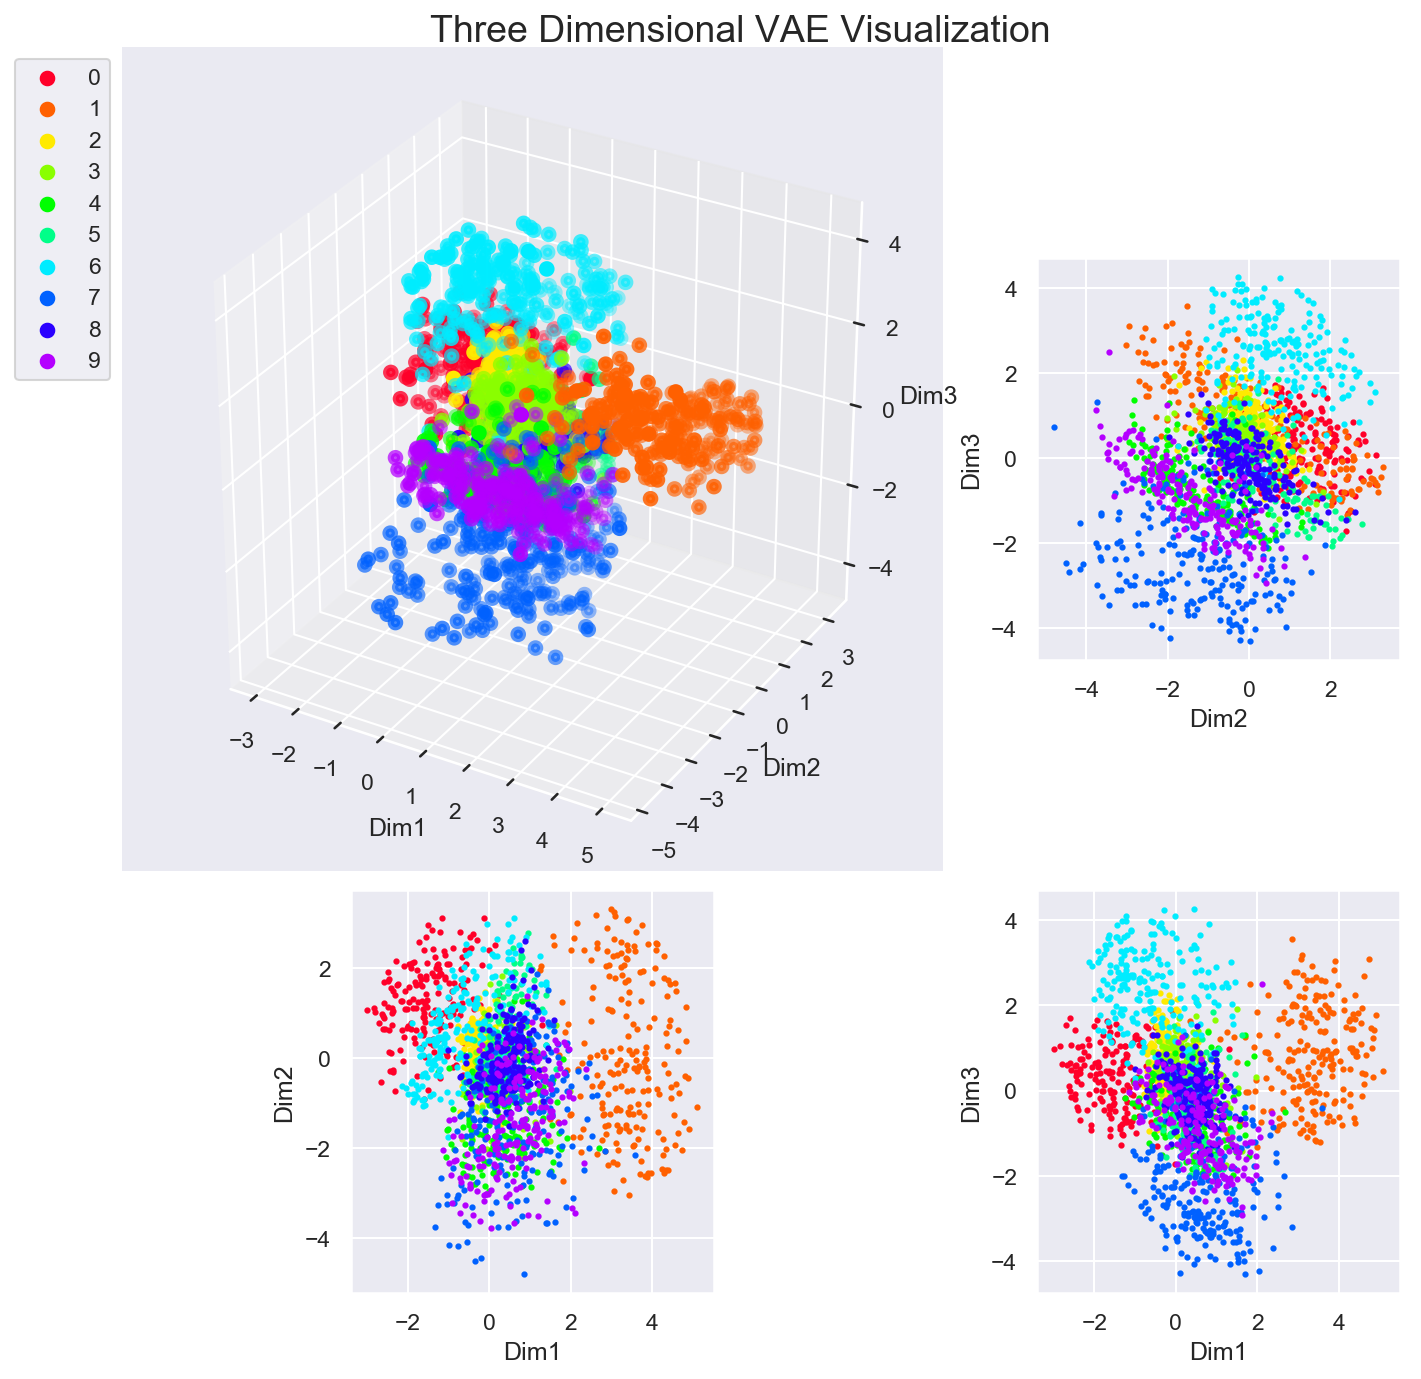

In [24]:
compo1 = X_valid_encoded[:, 0]
compo2 = X_valid_encoded[:, 1]
compo3 = X_valid_encoded[:, 2]
fig = plt.figure(dpi=150, figsize=(11,11))
grid = plt.GridSpec(6, 6, hspace=0.1, wspace=0.7)
ax1 = fig.add_subplot(grid[:4, :4], projection='3d')
ax1.set_xlabel("Dim1")
ax1.set_ylabel("Dim2")
ax1.set_zlabel("Dim3")
ax2 = fig.add_subplot(grid[4:, 1:3])
ax2.set_xlabel("Dim1")
ax2.set_ylabel("Dim2")
ax3 = fig.add_subplot(grid[1:3, 4:])
ax3.set_xlabel("Dim2")
ax3.set_ylabel("Dim3")
ax4 = fig.add_subplot(grid[4:, 4:])
ax4.set_xlabel("Dim1")
ax4.set_ylabel("Dim3")
for i in range(10):
    ax1.scatter(compo1[y_valid==i], compo2[y_valid==i], compo3[y_valid==i], c=[cmap(i/10)], linewidths=3, label='{}'.format(i))
    ax2.scatter(compo1[y_valid==i], compo2[y_valid==i], c=[cmap(i/10)], s=4)
    ax3.scatter(compo2[y_valid==i], compo3[y_valid==i], c=[cmap(i/10)], s=4)
    ax4.scatter(compo1[y_valid==i], compo3[y_valid==i], c=[cmap(i/10)], s=4)
ax1.legend(bbox_to_anchor=(0, 1))
fig.suptitle("Three Dimensional VAE Visualization", y=0.9, fontsize=18)

In [25]:
pairwise_distances(X_valid.reshape(-1, 28*28), metric='l2')

array([[ 0.        ,  9.42100445, 10.67313241, ..., 10.16469   ,
        11.5760933 ,  9.22415464],
       [ 9.42100445,  0.        , 11.10582627, ...,  8.79502498,
        10.14696239,  6.40801953],
       [10.67313241, 11.10582627,  0.        , ..., 10.9086529 ,
        12.11543225, 10.31027155],
       ...,
       [10.16469   ,  8.79502498, 10.9086529 , ...,  0.        ,
        10.67798203,  8.83110176],
       [11.5760933 , 10.14696239, 12.11543225, ..., 10.67798203,
         0.        , 10.98760267],
       [ 9.22415464,  6.40801953, 10.31027155, ...,  8.83110176,
        10.98760267,  0.        ]])

In [26]:
pairwise_distances(X_valid_encoded, metric='l2')

array([[0.       , 4.7534156, 0.8040339, ..., 0.528465 , 3.0004683,
        3.9586115],
       [4.7534156, 0.       , 5.4936504, ..., 4.663955 , 6.893258 ,
        4.717724 ],
       [0.8040339, 5.4936504, 0.       , ..., 0.9695801, 2.8289924,
        4.3054204],
       ...,
       [0.528465 , 4.663955 , 0.9695801, ..., 0.       , 3.4987986,
        3.4806812],
       [3.0004683, 6.893258 , 2.8289924, ..., 3.4987986, 0.       ,
        6.8387637],
       [3.9586115, 4.717724 , 4.30542  , ..., 3.4806812, 6.8387637,
        0.       ]], dtype=float32)

#### Pr. 1.3

Explain the decomposition of generalization error into approximation error, estimation
error, and optimization error.

In supervised learning, generalization error measures the prediction error on unseen data. Theoretically, it is composed of approximation error, estimation error and optimization error. Approximation error measures how far the best possible learned model is from the ideally optimal model. Estimation error measures how far the current learned model is from the best possible learned model. Optimization error is the smallest possible error among all the estimators, which is inherenly related to the estimation.

#### Pr. 1.4

Consider the latent Dirichlet allocation (LDA) or topic model. Write out how one would use Gibbs sampling to estimate the model parameters.

Generally, LDA assumes:

\begin{equation}
\begin{aligned}
&\pi_i\sim\text{Dir}(\pi_i|\alpha)\\
&z_{iv}\sim\text{Cat}(z_{iv}|\pi_i)\\
&\mathbf{b}_k\sim\text{Dir}(\mathbf{b}_k|\gamma)\\
&y_{iv}\sim\text{Cat}(y_{iv}|z_{iv}=k,\mathbf{B}),
\end{aligned}
\end{equation}

where $\pi_i$ is the topic distribution for each document, $z_iv$ is the topic for each word in each document, $\mathbf{b}_k$ is word distribution for each topic, $y_{iv}$ is the value of each word in each document. $i$ is the document index, $v$ is the word index and $k$ is the topic index.

$\pi_i, z_{iv}, \mathbf{b}_k$ are latent variables and $y_{iv}$ is observed variable. Based in distribution conjugacy, conditional distributions can be derived:

\begin{equation}
\begin{aligned}
&p(z_{iv}=k|\pi_i, \mathbf{b}_k)\propto \text{exp}(\text{log}\pi_{ik}+\text{log}b_{k,y_{iv}})\\
&p(\pi_i|z_{iv}=k,\mathbf{b}_k)=\text{Dir}(\alpha+\sum_{l}\mathbb{I}(z_{il}=k))\\
&p(\mathbf{b}_k|z_{iv}=k,\pi_i)=\text{Dir}(\gamma+\sum_i\sum_l\mathbb{I}(y_{il}=v,z_{il}=k))
\end{aligned}
\end{equation}

By plugging these distributions into the Gibbs sampling algorithm, we have:

(1) Randomly initialize $\pi_i$ and $\mathbf{b}_k$

(2) Draw $z_{iv}'\sim p(z_{iv}'|\pi_i, \mathbf{b}_k)$

(3) Draw $\pi_i'\sim p(\pi_i'|z_{iv}',\mathbf{b}_k)$

(4) Draw $\mathbf{b}_k'\sim p(\mathbf{b}_k'|z_{iv}',\pi_i')$

(5) Set $\pi_i=\pi_i', \mathbf{b}_k=\mathbf{b}_k'$

(6) Return (2) until convergence


Reference:

[1] https://wiseodd.github.io/techblog/2017/09/07/lda-gibbs/

#### Pr. 1.5

Consider the CFIAR-10 data set http://www.cs.toronto.edu/ kriz/cifar.html (you can use the entire data or a subset, just tell me what you did). This is a classifcation problem.

1.Compute the leave-on-out cross validation error for a Gaussian process regression model as well as a Convolutional Neural Network.

Data preprocessing:

In [27]:
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu,floatX=float32"
if K.backend()=='tensorflow':
    K.set_image_dim_ordering("th")

In [28]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

Gaussian process regression:

A random subset of $500$ data points are used.

In [29]:
from keras.utils import np_utils
np.random.seed(2019)
index = np.random.choice(50000, 500, replace=False)
X_cifar = train_features[index]/255
y_cifar = train_labels[index]
y_cifar = np_utils.to_categorical(y_cifar, num_classes)

In [7]:
error_list4 = []
for train_index, test_index in tqdm(loo.split(X_cifar),total=len(list(loo.split(X_cifar))),leave=False):
    X_train, X_test = X_cifar[train_index], X_cifar[test_index]
    y_train, y_test = y_cifar[train_index], y_cifar[test_index]
    X_train = X_train.reshape(-1, img_channels*img_rows*img_cols)
    X_test = X_test.reshape(-1, img_channels*img_rows*img_cols)
    gpr = GaussianProcessRegressor(kernel=kernel,alpha=0.1,random_state=0)\
    .fit(X_train, y_train)
    y_hat = np.argmax(gpr.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    error = (y_hat - y_true) ** 2
    error_list4.append(error)
I_cv = sum(error_list4) / len(error_list4)
print('Cross validation error for Gaussian process regression : {}'.format(I_cv[0]))

Cross validation error for Gaussian process regression : 12.53


Convolutional Neural Network:

A random subset of $50$ data points are used.

In [30]:
np.random.seed(2019)
index = np.random.choice(50000, 50, replace=False)
X_cifar = train_features[index]/255
y_cifar = train_labels[index]
y_cifar = np_utils.to_categorical(y_cifar, num_classes)

In [70]:
model = Sequential()
model.add(Conv2D(48, (3, 3), padding='same', input_shape=(3, 32, 32)))
model.add(Activation('relu'))
model.add(Conv2D(48, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(192, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(192, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.fit(X_cifar, y_cifar, batch_size=128, epochs=50, validation_split=0.2, verbose=2)

In [73]:
error_list3 = []
for train_index, test_index in tqdm(loo.split(X_cifar),total=len(list(loo.split(X_cifar))),leave=False):
    X_train, X_test = X_cifar[train_index], X_cifar[test_index]
    y_train, y_test = y_cifar[train_index], y_cifar[test_index]
    np.random.seed(2019)
    model.fit(X_train, y_train, batch_size=128, epochs=50, validation_data = (X_test, y_test), verbose=0)
    y_hat = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)
    error = (y_hat - y_true) ** 2
    error_list3.append(error)
I_cv = sum(error_list3) / len(error_list3)
print('Cross validation error for Convolutional neural network: {}'.format(I_cv[0]))

Cross validation error for Convolutional neural network: 2.02
